In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import xgboost as xgb


In [2]:
def load_and_clean_data(filepath):
    print("Loading dataset...")
    df = pd.read_csv(filepath)
    
    valid_labels = [
        'Non-Crypto', 'PRNG', 'RSA-1024', 'RSA-4096', 'ECC', 
        'XOR-CIPHER', 'SHA-1', 'SHA-224', 'AES-128', 'AES-192', 'AES-256'
    ]
    df_clean = df[df['label'].isin(valid_labels)].copy()
    
    cols_to_drop = ['filename', 'function_name', 'function_address', 
                    'source_file', 'algorithm'] # algorithm is redundant with label
    df_clean = df_clean.drop(columns=cols_to_drop, errors='ignore')
    
    bool_cols = ['has_aes_sbox', 'rsa_bigint_detected', 'has_aes_rcon', 'has_sha_constants']
    replace_dict = {'FALSE': 0, 'TRUE': 1, 'False': 0, 'True': 1, False: 0, True: 1}
    
    for col in bool_cols:
        if col in df_clean.columns:
            df_clean[col] = df_clean[col].fillna(0).map(replace_dict).fillna(0)


    cat_cols = ['architecture', 'compiler', 'optimization', 'label']
    num_cols = [c for c in df_clean.columns if c not in cat_cols]
    
    for col in num_cols:
        df_clean[col] = pd.to_numeric(df_clean[col], errors='coerce')
        
    initial_count = len(df_clean)
    df_clean = df_clean.dropna()
    print(f"Cleaned data: Kept {len(df_clean)} rows out of {initial_count} valid label rows.")
    
    return df_clean, cat_cols, num_cols


df_train, cat_cols, num_cols = load_and_clean_data('dataset.csv')

Loading dataset...
Cleaned data: Kept 7654 rows out of 7654 valid label rows.


In [3]:
def load_and_clean_data(filepath):
    print("Loading dataset...")
    df = pd.read_csv(filepath)
    
    valid_labels = [
        'Non-Crypto', 'PRNG', 'RSA-1024', 'RSA-4096', 'ECC', 
        'XOR-CIPHER', 'SHA-1', 'SHA-224', 'AES-128', 'AES-192', 'AES-256'
    ]
    df_clean = df[df['label'].isin(valid_labels)].copy()
    
    cols_to_drop = ['filename', 'function_name', 'function_address', 
                    'source_file', 'algorithm'] # algorithm is redundant with label
    df_clean = df_clean.drop(columns=cols_to_drop, errors='ignore')
    
    bool_cols = ['has_aes_sbox', 'rsa_bigint_detected', 'has_aes_rcon', 'has_sha_constants']
    replace_dict = {'FALSE': 0, 'TRUE': 1, 'False': 0, 'True': 1, False: 0, True: 1}
    
    for col in bool_cols:
        if col in df_clean.columns:
            df_clean[col] = df_clean[col].fillna(0).map(replace_dict).fillna(0)


    cat_cols = ['architecture', 'compiler', 'optimization', 'label']
    num_cols = [c for c in df_clean.columns if c not in cat_cols]
    
    for col in num_cols:
        df_clean[col] = pd.to_numeric(df_clean[col], errors='coerce')
        
    initial_count = len(df_clean)
    df_clean = df_clean.dropna()
    print(f"Cleaned data: Kept {len(df_clean)} rows out of {initial_count} valid label rows.")
    
    return df_clean, cat_cols, num_cols


df_test, cat_cols, num_cols = load_and_clean_data('test_dataset.csv')

Loading dataset...
Cleaned data: Kept 6718 rows out of 7752 valid label rows.


In [4]:
X_train = df_train.drop(columns=['label'])
y_train = df_train['label']

le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
class_names = le.classes_

sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)

categorical_features = ['architecture', 'compiler', 'optimization']
numerical_features = [c for c in X_train.columns if c not in categorical_features]

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

Dataset Information:
Training data shape: (7654, 42)
Test data shape: (6718, 42)
Number of classes: 11
Classes: ['AES-128', 'AES-192', 'AES-256', 'ECC', 'Non-Crypto', 'PRNG', 'RSA-1024', 'RSA-4096', 'SHA-1', 'SHA-224', 'XOR-CIPHER']
Training label distribution:
label
Non-Crypto    5263
PRNG           560
RSA-1024       322
RSA-4096       322
ECC            320
XOR-CIPHER     246
SHA-1          160
SHA-224        160
AES-192        104
AES-256        102
AES-128         95
Name: count, dtype: int64
Test label distribution:
label
Non-Crypto    4356
PRNG           589
AES-256        405
ECC            329
AES-192        315
AES-128        308
SHA-224        180
SHA-1          177
RSA-4096        59
Name: count, dtype: int64

TRAINING AND EVALUATING MODELS

--- Training RandomForest ---


/home/bhoomi/Desktop/compilerRepo/vestigo-data/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/bhoomi/Desktop/compilerRepo/vestigo-data/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/bhoomi/Desktop/compilerRepo/vestigo-data/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(

Accuracy: 0.7018
Detailed Classification Report:
              precision    recall  f1-score   support

     AES-128       0.67      0.01      0.01       308
     AES-192       0.25      0.00      0.01       315
     AES-256       0.41      0.02      0.04       405
         ECC       0.12      0.03      0.05       329
  Non-Crypto       0.77      0.98      0.86      4356
        PRNG       0.39      0.50      0.44       589
    RSA-1024       0.00      0.00      0.00         0
    RSA-4096       0.67      0.03      0.06        59
       SHA-1       0.78      0.33      0.46       177
     SHA-224       0.81      0.32      0.46       180
  XOR-CIPHER       0.00      0.00      0.00         0

    accuracy                           0.70      6718
   macro avg       0.44      0.20      0.22      6718
weighted avg       0.65      0.70      0.63      6718


Per-Class Performance:
AES-128: Precision=0.667, Recall=0.006, F1=0.013, Support=308.0
AES-192: Precision=0.250, Recall=0.003, F1=0.006, 

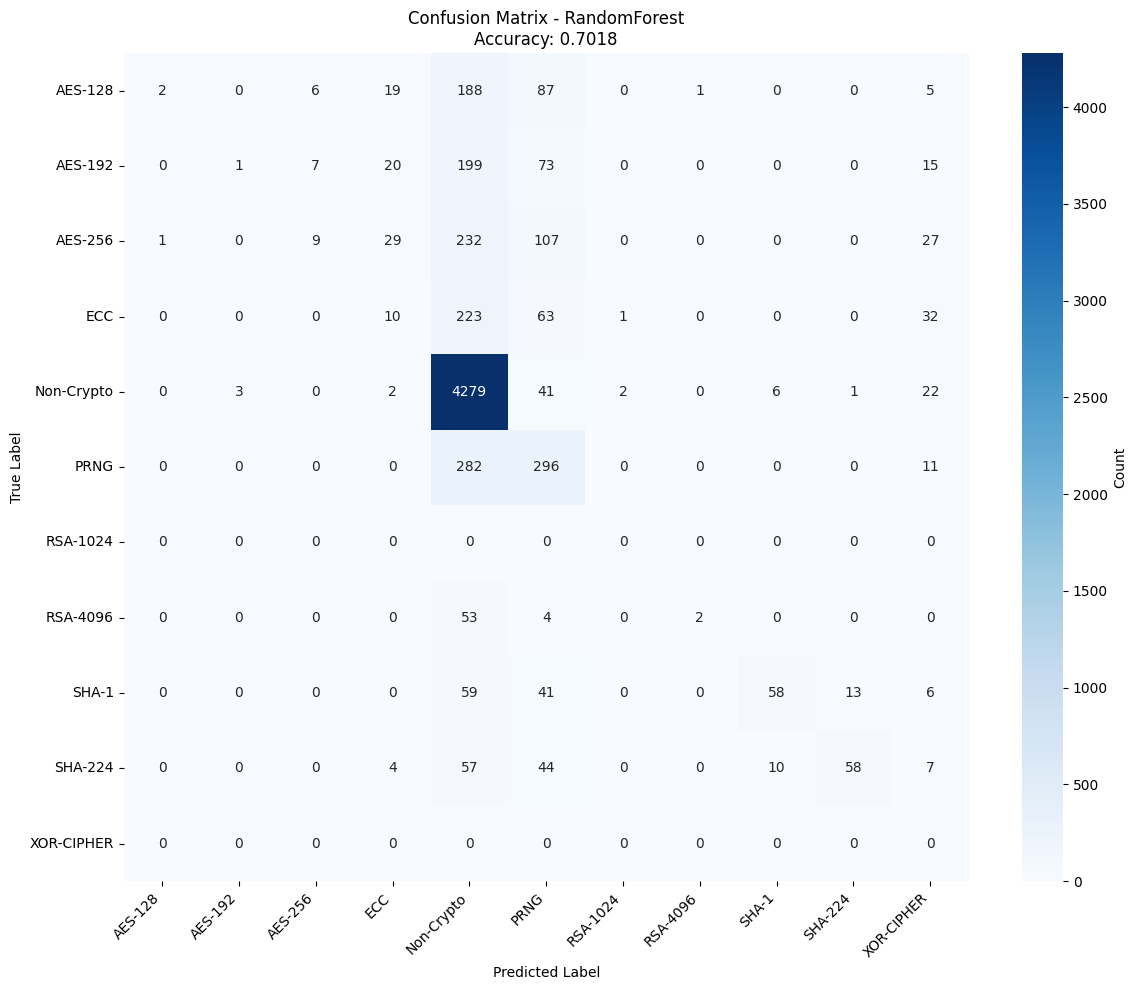

--------------------------------------------------

--- Training XGBoost ---


/home/bhoomi/Desktop/compilerRepo/vestigo-data/.venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [02:19:25] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/bhoomi/Desktop/compilerRepo/vestigo-data/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/bhoomi/Desktop/compilerRepo/vestigo-data/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/bhoomi/Desktop/co

Accuracy: 0.7359
Detailed Classification Report:
              precision    recall  f1-score   support

     AES-128       0.28      0.02      0.03       308
     AES-192       0.29      0.02      0.03       315
     AES-256       0.25      0.00      0.00       405
         ECC       0.10      0.09      0.10       329
  Non-Crypto       0.81      0.96      0.88      4356
        PRNG       0.65      0.82      0.72       589
    RSA-1024       0.00      0.00      0.00         0
    RSA-4096       0.11      0.12      0.12        59
       SHA-1       0.64      0.73      0.69       177
     SHA-224       0.77      0.47      0.59       180
  XOR-CIPHER       0.00      0.00      0.00         0

    accuracy                           0.74      6718
   macro avg       0.36      0.29      0.29      6718
weighted avg       0.67      0.74      0.68      6718


Per-Class Performance:
AES-128: Precision=0.278, Recall=0.016, F1=0.031, Support=308.0
AES-192: Precision=0.294, Recall=0.016, F1=0.030, 

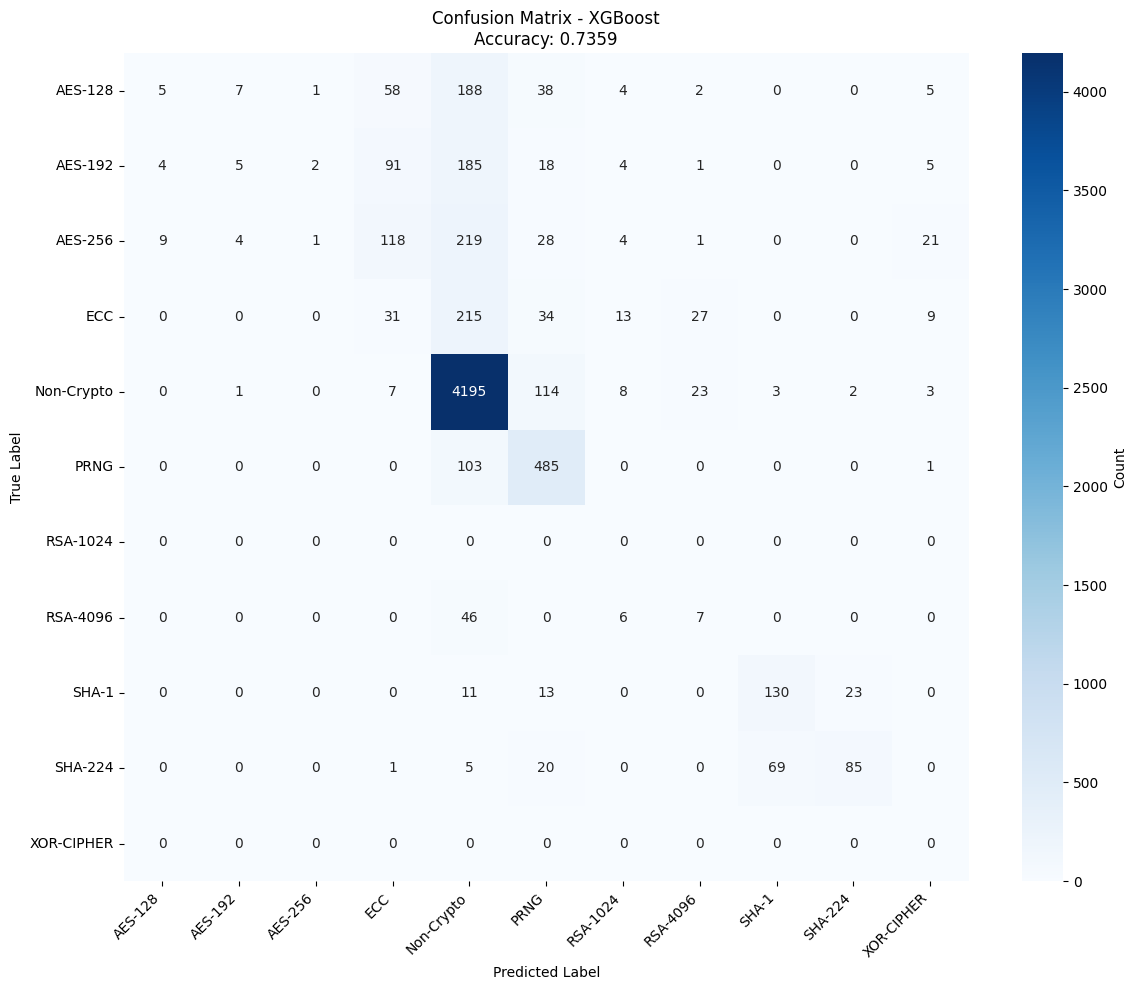

--------------------------------------------------

MODEL COMPARISON SUMMARY
RandomForest: 0.7018
XGBoost: 0.7359

Best Model: XGBoost (Accuracy: 0.7359)


In [5]:
rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=15,             
    min_samples_leaf=2,      
    class_weight='balanced',  
    random_state=42,
    n_jobs=-1
)

xgb_model = xgb.XGBClassifier(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=6,             
    subsample=0.8,           
    colsample_bytree=0.8,     
    objective='multi:softprob',
    eval_metric='mlogloss',
    random_state=42,
    use_label_encoder=False
)

pipelines = {
    'RandomForest': Pipeline(steps=[('preprocessor', preprocessor), ('classifier', rf_model)]),
    'XGBoost': Pipeline(steps=[('preprocessor', preprocessor), ('classifier', xgb_model)])
}

X_test = df_test.drop(columns=['label'])
y_test = df_test['label'] 
print("Dataset Information:")
print(f"Training data shape: {X_train.shape}")
print(f"Test data shape: {X_test.shape}")
print(f"Number of classes: {len(class_names)}")
print(f"Classes: {list(class_names)}")
print(f"Training label distribution:\n{y_train.value_counts()}")
print(f"Test label distribution:\n{y_test.value_counts()}")

results = {}
trained_models = {}
model_performance = {}

print("\n" + "="*60)
print("TRAINING AND EVALUATING MODELS")
print("="*60)

for name, pipe in pipelines.items():
    print(f"\n--- Training {name} ---")
    
    if name == 'XGBoost':
        pipe.fit(X_train, y_train_encoded, classifier__sample_weight=sample_weights)
    else:
        pipe.fit(X_train, y_train)
    
    if name == 'XGBoost':
        y_pred_encoded = pipe.predict(X_test)
        y_pred = le.inverse_transform(y_pred_encoded)
        
        y_pred_proba = pipe.predict_proba(X_test)
    else:
        y_pred = pipe.predict(X_test)
        y_pred_proba = pipe.predict_proba(X_test)
    
    acc = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, target_names=class_names, output_dict=True)
    
    results[name] = report
    trained_models[name] = pipe
    model_performance[name] = acc
    
    print(f"Accuracy: {acc:.4f}")
    print(f"Detailed Classification Report:")
    print(classification_report(y_test, y_pred, target_names=class_names))
    
    print(f"\nPer-Class Performance:")
    for class_name in class_names:
        if class_name in report:
            precision = report[class_name]['precision']
            recall = report[class_name]['recall']
            f1 = report[class_name]['f1-score']
            support = report[class_name]['support']
            print(f"{class_name}: Precision={precision:.3f}, Recall={recall:.3f}, F1={f1:.3f}, Support={support}")
    
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names, 
                cbar_kws={'label': 'Count'})
    plt.title(f'Confusion Matrix - {name}\nAccuracy: {acc:.4f}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()
    
    print("-" * 50)

best_model_name = max(model_performance, key=model_performance.get)
best_model = trained_models[best_model_name]
best_accuracy = model_performance[best_model_name]

print(f"\n" + "="*60)
print("MODEL COMPARISON SUMMARY")
print("="*60)
for name, acc in model_performance.items():
    print(f"{name}: {acc:.4f}")

print(f"\nBest Model: {best_model_name} (Accuracy: {best_accuracy:.4f})")

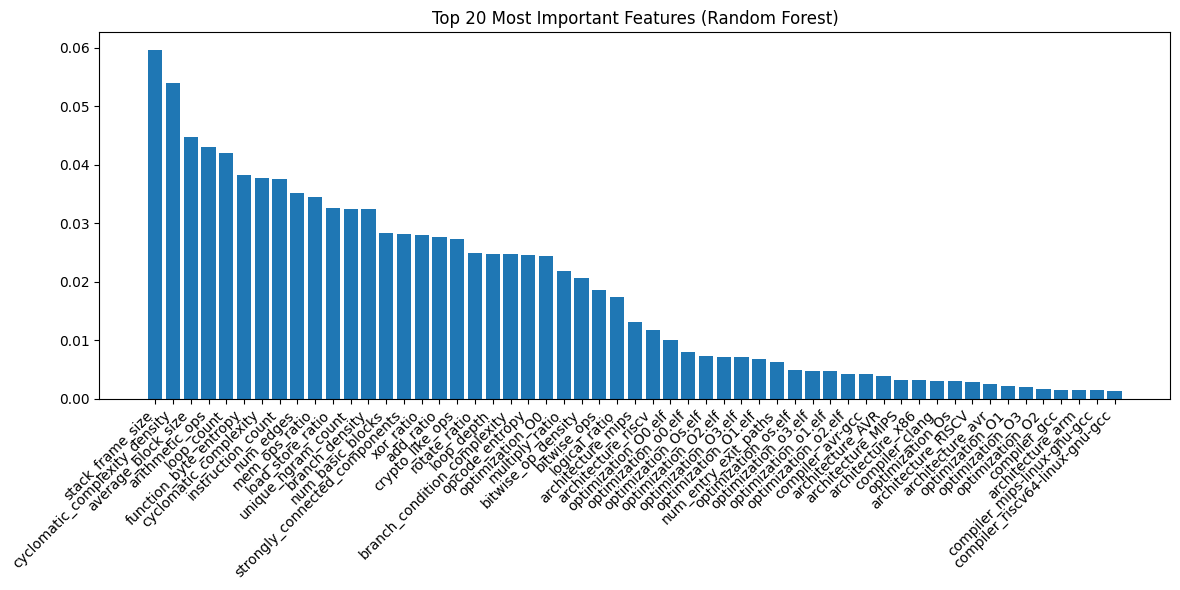

In [6]:
ohe = pipelines['RandomForest'].named_steps['preprocessor'].named_transformers_['cat']
ohe_feature_names = ohe.get_feature_names_out(categorical_features)
all_feature_names = numerical_features + list(ohe_feature_names)

importances = pipelines['RandomForest'].named_steps['classifier'].feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(12, 6))
plt.title("Top 20 Most Important Features (Random Forest)")
plt.bar(range(55), importances[indices[:55]], align="center")
plt.xticks(range(55), [all_feature_names[i] for i in indices[:55]], rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [7]:
import pickle
import joblib
import os
from datetime import datetime

os.makedirs('saved_models', exist_ok=True)

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
model_filename = f'saved_models/crypto_classifier_{best_model_name.lower()}_{timestamp}.pkl'
metadata_filename = f'saved_models/model_metadata_{timestamp}.pkl'

joblib.dump(best_model, model_filename)

metadata = {
    'label_encoder': le,
    'class_names': class_names,
    'categorical_features': categorical_features,
    'numerical_features': numerical_features,
    'model_name': best_model_name,
    'accuracy': best_accuracy,
    'feature_columns': list(X_train.columns),
    'training_date': datetime.now().isoformat(),
    'model_performance': model_performance
}

joblib.dump(metadata, metadata_filename)

print(f"Best model ({best_model_name}) saved to: {model_filename}")
print(f"Model metadata saved to: {metadata_filename}")
print(f"Model accuracy: {best_accuracy:.4f}")

current_model_path = 'saved_models/current_crypto_model.pkl'
current_metadata_path = 'saved_models/current_model_metadata.pkl'

joblib.dump(best_model, current_model_path)
joblib.dump(metadata, current_metadata_path)

print(f"Current model also saved as: {current_model_path}")
print(f"Current metadata also saved as: {current_metadata_path}")

Best model (XGBoost) saved to: saved_models/crypto_classifier_xgboost_20251202_022131.pkl
Model metadata saved to: saved_models/model_metadata_20251202_022131.pkl
Model accuracy: 0.7359
Current model also saved as: saved_models/current_crypto_model.pkl
Current metadata also saved as: saved_models/current_model_metadata.pkl


In [8]:
def predict_crypto_function(features_dict, model_path='saved_models/current_crypto_model.pkl', 
                          metadata_path='saved_models/current_model_metadata.pkl'):
    """
    Predict cryptographic function type from features.
    
    Args:
        features_dict: Dictionary containing feature values
        model_path: Path to saved model
        metadata_path: Path to saved metadata
    
    Returns:
        Dictionary with prediction, probabilities, and confidence score
    """
    model = joblib.load(model_path)
    metadata = joblib.load(metadata_path)
    
    import pandas as pd
    df = pd.DataFrame([features_dict])
    
    for col in metadata['feature_columns']:
        if col not in df.columns:
            if col in metadata['categorical_features']:
                df[col] = 'unknown' 
            else:
                df[col] = 0  
    
    df = df[metadata['feature_columns']]
    
    prediction_encoded = model.predict(df)[0]
    probabilities = model.predict_proba(df)[0]
    
    if metadata['model_name'] == 'XGBoost':
        prediction = metadata['label_encoder'].inverse_transform([prediction_encoded])[0]
    else:
        prediction = prediction_encoded
    
    confidence = max(probabilities)
    
    prob_dict = {}
    for i, class_name in enumerate(metadata['class_names']):
        prob_dict[class_name] = probabilities[i]
    
    return {
        'prediction': prediction,
        'confidence_score': confidence,
        'probabilities': prob_dict,
        'model_used': metadata['model_name'],
        'model_accuracy': metadata['accuracy']
    }

def example_prediction():
    
    sample_features = {
        'architecture': 'x86',
        'compiler': 'gcc',
        'optimization': 'O2',
        'function_size': 150,
        'num_basic_blocks': 12,
        'num_instructions': 85,
        'cyclomatic_complexity': 8,
        'has_aes_sbox': 0,
        'rsa_bigint_detected': 0,
        'has_aes_rcon': 0,
        'has_sha_constants': 0,
        'num_arithmetic_ops': 25,
        'num_logical_ops': 10,
        'num_memory_ops': 30,
        'num_control_flow_ops': 8,
        'entropy': 7.2,
        'num_constants': 5,
        'avg_instruction_length': 3.5,
        'register_usage_density': 0.6
    }
    
    try:
        result = predict_crypto_function(sample_features)
        
        print(" PREDICTION RESULTS")
        print("=" * 50)
        print(f"Predicted Function Type: {result['prediction']}")
        print(f"Confidence Score: {result['confidence_score']:.4f}")
        print(f"Model Used: {result['model_used']}")
        print(f"Model Training Accuracy: {result['model_accuracy']:.4f}")
        
        print(f"\nClass Probabilities:")
        for class_name, prob in sorted(result['probabilities'].items(), key=lambda x: x[1], reverse=True):
            print(f"  {class_name}: {prob:.4f} ({prob*100:.1f}%)")
            
        return result
    except Exception as e:
        print(f"Error making prediction: {str(e)}")
        return None

print("Testing prediction function with sample data:")
example_prediction()

Testing prediction function with sample data:
 PREDICTION RESULTS
Predicted Function Type: Non-Crypto
Confidence Score: 0.9746
Model Used: XGBoost
Model Training Accuracy: 0.7359

Class Probabilities:
  Non-Crypto: 0.9746 (97.5%)
  ECC: 0.0091 (0.9%)
  SHA-224: 0.0050 (0.5%)
  RSA-1024: 0.0032 (0.3%)
  RSA-4096: 0.0028 (0.3%)
  AES-128: 0.0014 (0.1%)
  AES-192: 0.0011 (0.1%)
  XOR-CIPHER: 0.0010 (0.1%)
  PRNG: 0.0010 (0.1%)
  AES-256: 0.0009 (0.1%)
  SHA-1: 0.0002 (0.0%)


{'prediction': 'Non-Crypto',
 'confidence_score': np.float32(0.9745548),
 'probabilities': {'AES-128': np.float32(0.0013734528),
  'AES-192': np.float32(0.0010881014),
  'AES-256': np.float32(0.0008734444),
  'ECC': np.float32(0.009063259),
  'Non-Crypto': np.float32(0.9745548),
  'PRNG': np.float32(0.0009510259),
  'RSA-1024': np.float32(0.0031709543),
  'RSA-4096': np.float32(0.0028190627),
  'SHA-1': np.float32(0.00017302496),
  'SHA-224': np.float32(0.004960441),
  'XOR-CIPHER': np.float32(0.0009724954)},
 'model_used': 'XGBoost',
 'model_accuracy': 0.7359333134861566}